# Revenue Prediction Based on Website Traffic

Created by: Stefan Lauren

Date: Dec 2019

### Data Science Task

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime
import itertools
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.var_model import VAR
import warnings
warnings.filterwarnings('ignore')

## 1. Data Collection

In [4]:
df = pd.read_csv('Website traffic.csv', sep='\t', header=None)
df = df.T
#assign first row as column names
df.columns = df.iloc[0]
#delete first row to remove the column names
df = df.drop([0])

In [5]:
df.head()

,Month,Traffic,Sales,Revenue
1,May-15,48234,824,83452.24
2,juil-15,56972,923,"$77,647.48"
3,Aug-15,46750,594,"$49,415.73"
4,sept-15,47378,943,"$88,097.31"
5,oct-15,53297,453,"$37,732.41"


Data are loaded successfully!

## 2. Data Exploration & Preprocessing

In [6]:
df.columns

Index(['Month', 'Traffic', 'Sales', 'Revenue'], dtype='object', name=0)

There are four features. 'Month', 'Traffic', and 'Sales' are input features for the prediction model. 'Revenue' is the prediction target, which means this is a regression task.

In [7]:
df.describe()

,Month,Traffic,Sales,Revenue
count,36,36,34,36
unique,36,36,33,36
top,Dec-17,573812,943,"$142,304.52"
freq,1,1,2,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 1 to 36
Data columns (total 4 columns):
Month      36 non-null object
Traffic    36 non-null object
Sales      34 non-null object
Revenue    36 non-null object
dtypes: object(4)
memory usage: 864.0+ bytes


In [9]:
df.nunique()

0
Month      36
Traffic    36
Sales      33
Revenue    36
dtype: int64

#### Observations

These are time series data worth three years of sales-revenue with traffice of an online retail store.

1. Month: corresponding month and year of each observation
2. Traffic: the amount of data sent and received by visitors to a website
3. Sales: the amount of products sold
4. Revenue: the amount of the income / surplus

The types of the features are object, which mean the data are not clean (containing multiple types in the same feature).
The 'Sales' has a few duplicate values, possibly missing values.

#### Action

Before we continue further, the types of the data needs to be changed for the analysis to be done smoothly.

1. Month: datetime with format YYYY-MM-DD, with DD = 01 to make it consistent. Special case for this feature will be explained below
2. Traffic: integer, because only five observations are float type so I decide to round them
3. Sales: float, so that it is suitable for handling missing values
4. Revenue: float, and I need to remove the dollar sign and commas

For the 'Month' feature, observing the first row and second row, we notice that the month 'June' is missing. Therefore, I decide to process the first row as 'June' because the dataset ends at 'May', which would make it a perfect three years time series data. Another observation on the feature, there are a lot of mispelling, so I need to process it iteratively rather than using pandas functionality.

In [10]:
# Convert the 'Month' feature into datetime.date format
for i, row in df.iterrows():
    month = (i + 5) % 12 if (i + 5) % 12 != 0 else 12
    date_str = row['Month'].split('-')[1] + '-' + str(month) + '-1'
    df['Month'][i] = datetime.strptime(date_str, "%y-%m-%d").date()
    
df['Month'] = df['Month'].astype('datetime64')

In [11]:
# Round the traffic and convert into integer
df['Traffic'] = df['Traffic'].astype('float64').round().astype('int64')

In [12]:
# Convert the type into float
df['Sales'] = df['Sales'].astype('float64')

In [13]:
# Remove commas and dollar sign, then convert the type into float
df['Revenue'] = df['Revenue'].str.replace(',', '')
df['Revenue'] = df['Revenue'].str.replace('$', '')
df['Revenue'] = df['Revenue'].astype('float64')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 1 to 36
Data columns (total 4 columns):
Month      36 non-null datetime64[ns]
Traffic    36 non-null int64
Sales      34 non-null float64
Revenue    36 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 2.4 KB


In [15]:
df.head()

,Month,Traffic,Sales,Revenue
1,2015-06-01,48234,824.0,83452.24
2,2015-07-01,56972,923.0,77647.48
3,2015-08-01,46750,594.0,49415.73
4,2015-09-01,47378,943.0,88097.31
5,2015-10-01,53297,453.0,37732.41


Now we have the dataset with each feature has specific type.

### Initial Correlation

In [16]:
def plot_correlation(df):
    f,ax = plt.subplots(figsize=(4, 4))
    sns_plot = sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax)

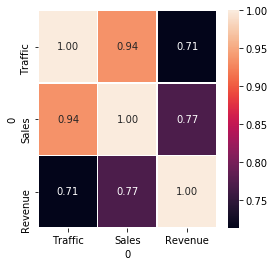

In [17]:
plot_correlation(df)

The plot shows that Traffic and Sales are somehow well correlated. Interestingly, Revenue and Sales have low correlation score. It might be because of some seasonal promotion or events; or the data are not cleaned so that they give an inaccurate correlation plot. I will check the plot again later after cleaning the data more.

### Outliers

To check the outliers, I plot feature 'Traffic', 'Sales', and 'Revenue' to see if there is any discrepancies on the plot.

In [18]:
def linePlot(x, y, title, xlabel, ylabel):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.show()

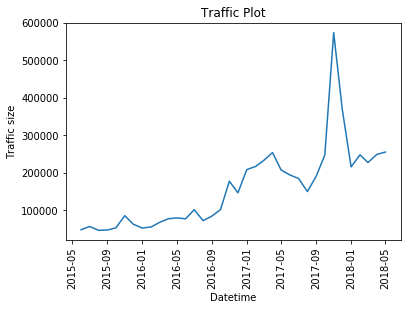

In [19]:
linePlot(df['Month'], df['Traffic'], 'Traffic Plot', 'Datetime', 'Traffic size')

Traffic plot has an upward trend. One interesting point on the Traffic plot is the highest value on 2017-12. I need to check the other plot first before I could tell whether it is an outlier or not.

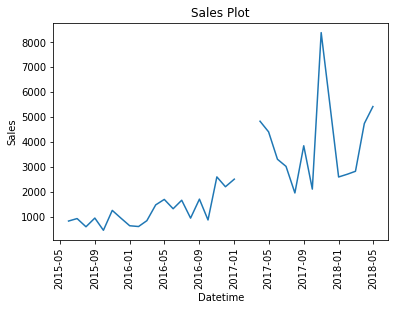

In [20]:
linePlot(df['Month'], df['Sales'], 'Sales Plot', 'Datetime', 'Sales')

Again, the highest peak is on 2017-12 with overall upward trend. Another interesting point is the missing values in the middle between 2017-01 and 2017-05. The missing values will be investigated further in the next subsection.

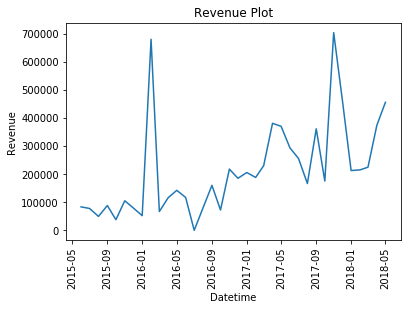

In [21]:
linePlot(df['Month'], df['Revenue'], 'Revenue Plot', 'Datetime', 'Revenue')

There are two peaks on the Revenue plot. Considering the upward trend, the peak on 2016-02 is clearly an outlier. The other peak is on 2017-12, which means I can assume that this point is not an outlier as it is consistent with the trend (higher traffic means higher sales, thus higher revenue as well). There might be a special event on that period that greatly boosted the Revenue.

There is also a zero revenue on 2016-07, which does not make sense because at that time, the traffic and sales are not zeros. So, this point is also considered as outlier.

#### Action

As we have a very limited size of dataset, I want to avoid dropping the outlier observations. Another way to solve the outliers is to replace its value to correspond to the overall trend. Therefore, I could calculate the average revenue per sales for other Months, and use the average revenue per sales to count the new revenue on the outliers.

In [22]:
# Get the average revenue per sales on the data except for the outliers and missing values
avg = 0.0
count = 0
outlier_date = datetime.strptime('2016-02-01', "%Y-%m-%d")
for _, row in df.iterrows():
    if(np.isnan(row['Sales']) or row['Revenue'] == 0 or row['Month'] == outlier_date):
        continue
    avg += row['Revenue']/row['Sales']
    count += 1
    
avg = avg/count
print('Average revenue per sales = ', avg)

Average revenue per sales =  84.76296594447403


In [23]:
# Replace the outlier value with its sales * avg
df['Revenue'][df['Month'] == outlier_date] = df['Sales'][df['Month'] == outlier_date] * avg
df['Revenue'][df['Revenue'] == 0] = df['Sales'][df['Revenue'] == 0] * avg

df['Revenue'] = df['Revenue'].round(2)

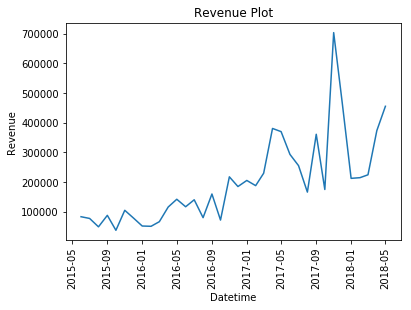

In [24]:
linePlot(df['Month'], df['Revenue'], 'Revenue Plot', 'Datetime', 'Revenue')

Now, the Revenue plot is cleaned of outliers as every point on the plot is having similar trend.

### Missing value

In [25]:
# Return the number of missing values for each feature and its percentage
def check_missing_value(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    missing_values = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    pd.set_option('display.max_rows', None)
    return missing_values

In [26]:
check_missing_value(df)

,Total,Percent
0,,
Sales,2,5.555556
Revenue,0,0.000000
Traffic,0,0.000000
Month,0,0.000000


#### Observations

Feature 'Sales' has two missing values. However, we could not delete those two observations as in this case, we only have a very small size of dataset. Therefore, they hold important values to ensure better model training.

#### Action

One way to solve the missing values is to replace them by an estimation based on the average revenue per sales. I have already calculated the average revenue per sales on the previous step, so I will use to to replace the missing values on sales by calculating its revenue divided by the average.

In [27]:
# Replace nan values with the revenue/avg
for i, row in df.iterrows():
    if(np.isnan(row['Sales'])):
        df['Sales'][i] = row['Revenue']/avg
        
df['Sales'] = df['Sales'].round()

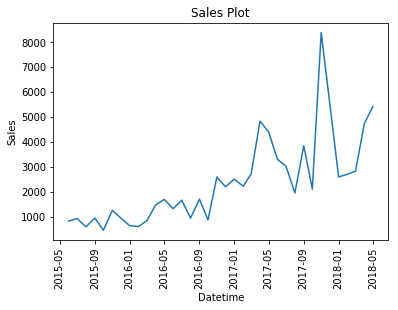

In [28]:
linePlot(df['Month'], df['Sales'], 'Sales Plot', 'Datetime', 'Sales')

As we can see, the missing values dissappear and the new replacing values are representative as we use the average of all data.

### Correlation

As I finished cleaning the data, it is interesting to see the new correlation plot.

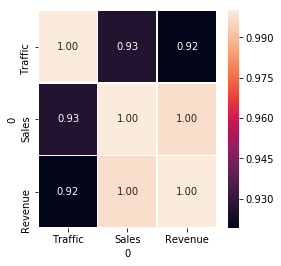

In [29]:
plot_correlation(df)

#### Observations

Feature 'Sales' and 'Revenue' are now perfectly correlated as we suspected before. This could happen as I cleaned both features in the previous steps. This could also mean that the cleaning methods were suitable and acceptable.

Feature 'Traffic' is less correlated with either 'Sales' or 'Revenue'. However, the correlation score indicates that it is still closely correlated. Therefore, it might be interesting to also include this feature to predict the revenue.

#### Summary

There are many problems with the raw data such as inconsistensies, outliers and missing values. However, the trends on each feature seems to be upward, making cleaning process relatively easier.

By this point, the data are cleaned thoroughly with detailed steps as below:
1. Formatting 'Month' to date type to make it consistent
2. Replacing outliers value by making use of average revenue per sales on the data
3. Replacing missing values by making use of average revenue per sales on the data

Now, we can move to the modelling part. For the modelling, I will try two approaches, which is univariate time series forecasting (ARIMA/SARIMA) and multivariate time series forecasting (VAR), and choose the better approach for forecasting.

## 3. Pre-Modelling

For the univariate approach, I will use ARIMA method to forecast the revenue. ARIMA (Autoregressive Integrated Moving Average) is a forecasting method for single variable time series data. I will give the plots of seasonality, trend and noise of the data that are related to the parameters in ARIMA method.

In [30]:
# Set Month as the index for time series forecasting for both univariate and multivariate methods
df = df.set_index('Month')
df.index

DatetimeIndex(['2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01',
               '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01',
               '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01',
               '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01',
               '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01',
               '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

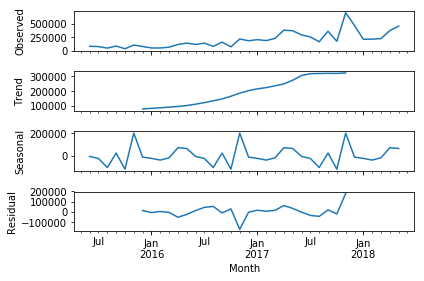

In [31]:
decomposition = sm.tsa.seasonal_decompose(df['Revenue'], model='additive')
fig = decomposition.plot()
plt.show()

The plots above show the upward trend as I mentioned in the previous section. Moreover, the revenues are not stable as it seems to be seasonal. Therefore, I need to use an extension of ARIMA method, which is Seasonal ARIMA (SARIMA).

## 4. Modelling

### Univariate

I will apply Seasonal ARIMA / SARIMA model to forecast the revenue.

In [32]:
# Set the combination of parameters representing seasonal, trend and noise (p,d,q)
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 8) for x in list(itertools.product(p, d, q))]

In [33]:
# Only model 'Revenue'
revenue_df = df.drop(['Traffic', 'Sales'], axis=1)

Below I use Grid Search method to find the best combination of parameters for SARIMA:

In [34]:
lowest_aic = 1000000
best_param = ()
best_param_seasonal = ()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(revenue_df,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit()
        
        if(results.aic < lowest_aic):
            lowest_aic = results.aic
            best_param = param
            best_param_seasonal = param_seasonal
        
        print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 8) - AIC:971.3658449687862
ARIMA(0, 0, 0)x(0, 0, 1, 8) - AIC:751.4761999802378
ARIMA(0, 0, 0)x(0, 1, 0, 8) - AIC:722.9633818421925
ARIMA(0, 0, 0)x(0, 1, 1, 8) - AIC:1753.2239582625366
ARIMA(0, 0, 0)x(1, 0, 0, 8) - AIC:744.8296304145643
ARIMA(0, 0, 0)x(1, 0, 1, 8) - AIC:721.3724228185092
ARIMA(0, 0, 0)x(1, 1, 0, 8) - AIC:541.3611472717246
ARIMA(0, 0, 0)x(1, 1, 1, 8) - AIC:1756.978936225646
ARIMA(0, 0, 1)x(0, 0, 0, 8) - AIC:931.695585691018
ARIMA(0, 0, 1)x(0, 0, 1, 8) - AIC:712.4329695303176
ARIMA(0, 0, 1)x(0, 1, 0, 8) - AIC:694.9994769731115
ARIMA(0, 0, 1)x(0, 1, 1, 8) - AIC:1673.9630059687363
ARIMA(0, 0, 1)x(1, 0, 0, 8) - AIC:761.9905433902609
ARIMA(0, 0, 1)x(1, 0, 1, 8) - AIC:709.6321578027971
ARIMA(0, 0, 1)x(1, 1, 0, 8) - AIC:541.9441943934936
ARIMA(0, 0, 1)x(1, 1, 1, 8) - AIC:1677.598876132578
ARIMA(0, 1, 0)x(0, 0, 0, 8) - AIC:900.600472992945
ARIMA(0, 1, 0)x(0, 0, 1, 8) - AIC:704.2540278588527
ARIMA(0, 1, 0)x(0, 1, 0, 8) - AIC:702.6926515770938
ARIMA(0, 1, 

In [35]:
print('The lowest AIC value is = ', lowest_aic)
print('The best param is = ', best_param)
print('The best seasonal param is = ', best_param_seasonal)

The lowest AIC value is =  486.70167814565605
The best param is =  (1, 1, 1)
The best seasonal param is =  (1, 1, 0, 8)


AIC value get larger if more feaures are used to get a 'good' fit model, and AIC value gets smaller if less features are used to achieve the same 'good' fit model. So, we are interested in the lowest AIC value of 485.65735863062497 to be called the optimal value. Thus, the optimal parameters are given by (1, 1, 1) and (1, 1, 0, 8) respectively.

#### Fitting

In [36]:
model_sarima = sm.tsa.statespace.SARIMAX(revenue_df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 8),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_sarima = model_sarima.fit()

I will produce some plots to see if there is any weird behaviour on the model.

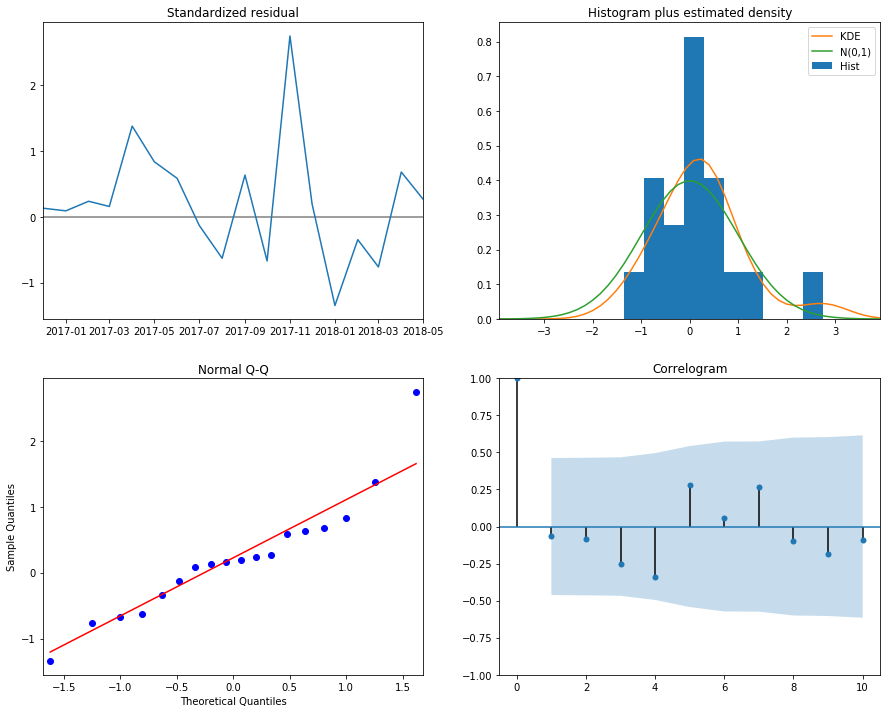

In [37]:
results_sarima.plot_diagnostics(figsize=(15, 12))
plt.show()

The goal is to get the residual of the model as normally distributed as it could. The model shows that it is not perfectly normally distributed, but good enough.

### Multivariate

I will use Vector Auto Regression / VAR method that understands the relationship of multiple variables.

In [38]:
model_var = VAR(endog=df)
results_var = model_var.fit()

## 5. Evaluation

### Univariate

To check the performance of the model further, I will try to compare the last one year of the revenue data with the predicted revenue.

In [39]:
pred_sarima = results_sarima.get_prediction(start=pd.to_datetime('2015-06-01'), dynamic=False)
pred_ci = pred_sarima.conf_int()

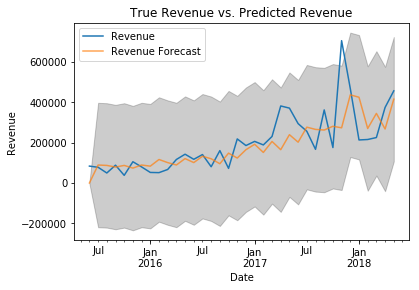

In [40]:
ax = revenue_df['2015':].plot(label='Observed')
pred_sarima.predicted_mean.plot(ax=ax, label='Revenue Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
plt.title('True Revenue vs. Predicted Revenue')
plt.legend()

plt.show()

The plot above shows that the model could capture the upward trend relatively well. If we look closer, while it is true that the predicted revenue sometimes has big difference with the true revenue, but the more detailed trend is also captured very well.

In [41]:
revenue_pred = pred_sarima.predicted_mean
revenue_true = revenue_df['2015-06-01':]['Revenue']
mse = ((revenue_pred - revenue_true) ** 2).mean()
print('The Root Mean Squared Error of the prediction is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of the prediction is 106469.17


Considering that the minimum value of 'Revenue' is 37732.41 and the maximum is 703806.81, the RMSE although it is not ideal, but I believe it is accepted.

### Multivariate

In [42]:
pred_var = results_var.forecast(results_var.y, steps=len(df))

In [43]:
# Converting predictions to count mse
cols = df.columns
mse_df = pd.DataFrame(index=range(0,len(pred_var)),columns=[cols])

for j in range(0,3):
    for i in range(0, len(pred_var)):
        mse_df.iloc[i,j] = (pred_var[i,j] - df.iloc[i,j]) **2
        
        
mse_df.head()

0,Traffic,Sales,Revenue
0,9.64819e+09,3.39936e+06,2.16189e+10
1,5.29081e+09,928691,7.04051e+09
2,9.5012e+09,2.16348e+06,1.55427e+10
3,1.1732e+10,1.86922e+06,1.12501e+10
4,1.13587e+10,3.83706e+06,2.72666e+10


In [44]:
#check rmse
for i in cols:
    mse = (mse_df[i]).mean()
    print('RMSE value for', i, 'is : ', np.sqrt(mse[0]))

RMSE value for Traffic is :  106457.79288522809
RMSE value for Sales is :  1708.4657329135819
RMSE value for Revenue is :  142641.67394138436


Compared to the univariate method, the RMSE for revenue is higher. However, as the model incorporate multiple variables, it might give different forecasting result.

Therefore, for the forecasting, I will only use the univariate (SARIMA) method.

## 6. Forecasting

Below is the step to forecast three years in the future to get a better look at the prediction.

In [45]:
pred_uc = results_sarima.get_forecast(steps=datetime.strptime('2021-05-01', "%Y-%m-%d"))
pred_ci = pred_uc.conf_int()

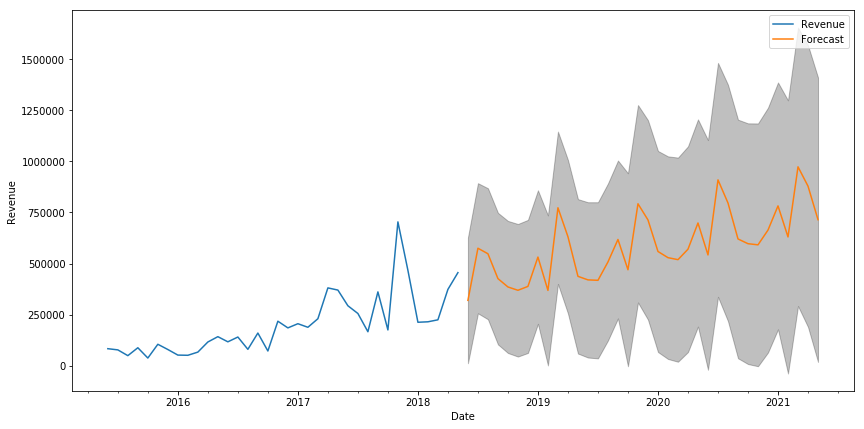

In [46]:
ax = revenue_df.plot(label='Observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
plt.legend()
plt.show()

The forecast shows that it follows the upward trend. It is also shows the seasonal trend obviously.
The forecast becomes less and less confident the longer the date is, and this is understandable as there are more unknown factors in the future.

#### One year forecast

Below I will use the model to forecast the revenue for the next 12 months (until 2019-05-01) and save it into csv file.

In [47]:
one_year_fc = results_sarima.get_forecast(steps=datetime.strptime('2019-05-01', "%Y-%m-%d"))

In [48]:
csv_data = {}
csv_data['Month'] = one_year_fc.predicted_mean.index.strftime("%b-%y")
csv_data['Predicted_revenue'] = one_year_fc.predicted_mean.round(2)

In [49]:
# Convert to Pandas Dataframe to store into csv
df = pd.DataFrame.from_dict(csv_data)
df.to_csv('revenue_forecasting.csv', index=False)

In [50]:
df_fc = pd.read_csv('revenue_forecasting.csv')
df_fc.head()

,Month,Predicted_revenue
0,Jun-18,319868.42
1,Jul-18,574919.84
2,Aug-18,547898.32
3,Sep-18,426327.59
4,Oct-18,385448.73


### Conclusion & Future Works

The aim for this work is to forecast one year revenue based on the three years historical data on 'Traffic', 'Sales' and 'Revenue'. At the beginning, the data are not ready for modelling as I need to clean them up first. Handling inconsistensies, outliers, missing values, formats and data type are several things that was done to the data. The resulting cleaned data have a good correlation among all the features.

Using Seasonal ARIMA method to model the data, there are three important factors that need to be inspected: trend, seasonal and noise. With grid search method to try all possible combination of parameters to get the best one, the final model was fitted. Finally, the forecast of one year revenue was saved into csv file.

Below are some future works that could be done to improve the performance:
1. Get more data to get more detailed trend and better prediction of the revenue
2. Try different Seasonal ARIMA parameters for better model fitting
3. Engineer new feature to reflect more accurate revenue
4. Try other machine learning methods to predict revenue